In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Create the Data

In [2]:
SZ = 100
a_star = 1
b_star = 2

x_vals = np.random.randint(0, SZ, SZ)
y_vals = a_star * x_vals + b_star + np.random.normal(loc=0.0, scale=1.0, size=SZ) 

df = pd.DataFrame({'x': x_vals, 'y': y_vals})
df.head()

,x,y
0,73,78.081106
1,85,88.955848
2,70,71.271077
3,85,87.460204
4,39,40.388635


In [3]:
df.shape

(100, 2)

In [4]:
df['actual_output'] = a_star * df['x'] + b_star
df.head()

,x,y,actual_output
0,73,78.081106,75
1,85,88.955848,87
2,70,71.271077,72
3,85,87.460204,87
4,39,40.388635,41


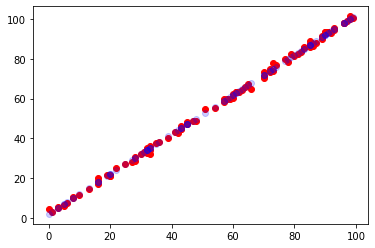

In [5]:
fig, ax = plt.subplots(1, 1)
ax.scatter(df['x'], df['y'], c='r', label='noisy output')
ax.scatter(df['x'], df['actual_output'], c='b', label='actual output',alpha=0.2)

## The Loss Function and Gradient

We assume that the loss function is the standard mean squared loss. 
$$
    \mathscr{L}(a, b) = \frac{1}{2M} \sum_{i = 1}^{M} (a x_i + b - y_i)^2
$$
The gradient $\nabla_{a, b} \mathscr{L}$ is then given by:
$$
    \nabla_{a, b} \mathscr{L} = 
        \left ( 
                \begin{array}{c}
                    \frac{1}{M} \sum_{i = 1}^{M} (a x_i + b - y_i) x_i \\
                    \frac{1}{M} \sum_{i = 1}^{M} (a x_i + b - y_i)
                \end{array}
        \right )
$$
Initially,let's look at vanilla gradient descent. It uses the entire data set to compute the gradient and then updates the parameters $a$ and $b$ as follows:
$$
\begin{align*}
    a_{t + 1} & = a_{t} - \eta \frac{1}{M} \sum_{i = 1}^{M} (a_{t} x_i + b_{t} - y_i) x_i \\
    b_{t + 1} & = b_{t} - \eta \frac{1}{M} \sum_{i = 1}^{M} (a_{t} x_i + b_{t} - y_i).
\end{align*}
$$
Here $\eta$ is the learning rate.

In [6]:
def loss(a: float, b: float, data_points: np.array):
    loss = 0.5 * np.mean(np.square(a * data_points[:, 0] + b - data_points[:, 1]))
    return loss

def grad(a: float, b: float, data_points: np.array, eta=1e-6):
    """
        Assume that data_points is an np.array with shape (-1, 2)
    """
    m = len(data_points)
    if m == 0:
        return a, b
    
    
    assert data_points.shape[1] == 2
    
    grad_a = np.mean((a * data_points[:, 0] + b - data_points[:, 1]) * data_points[:, 0])
    grad_b = np.mean(a * data_points[:, 0] + b - data_points[:, 1])
    
    a_new = a - eta * grad_a
    b_new = b - eta * grad_b
    
    return a_new, b_new

In [7]:
def grad_desc(a: float, b: float, data_points: np.array, num_iter=100):
    history = np.zeros(shape=(num_iter + 1, 3))
    history[0, :] = [a, b, loss(a, b, data_points)]
    
    for idx in range(num_iter):
        a, b = grad(a, b, data_points)
        history[idx + 1, :] = [a, b, loss(a, b, data_points)] 
    return history

def stochastic_grad_desc(a: float, b: float, 
                         data_points: np.array, 
                         num_iter=100):
    history = np.zeros(shape=(num_iter + 1, 3))
    history[0, :] = [a, b, loss(a, b, data_points)]
    
    for idx in range(num_iter):
        for l in range(len(data_points)):
            a, b = grad(a, b, data_points[l, :].reshape(-1, 2))
        history[idx + 1, :] = [a, b, loss(a, b, data_points)]
    
    return history

In [8]:
hist1 = grad_desc(a=0.5, b=-1, data_points=df[['x', 'y']].values, num_iter=10000)
hist1[-1]

array([ 1.04309378, -0.98555874,  1.50340083])

In [9]:
hist2 = stochastic_grad_desc(a=0.5, b=-1, data_points=df[['x', 'y']].values, num_iter=10000)
hist2[-1]

array([ 1.03444475, -0.39176182,  1.14605346])

## Gradient Descent with Momentum

In the momentum based method, one keeps track of the "old" gradient. The update to the parameters involves adding a pre-defined contribution of the old gradient to the new gradient. If the old and the new gradient vectors point in the same direction, this will accelerate the parameter changes; if they point in different directions, this will slow down the parameter change process and prevent fluctuations. 

This involves using a variable to keep track of the old gradients:
$$
\begin{align*}
    v_t & = \gamma v_{t - 1} + \nabla_{a, b} \mathscr{L}(a, b) \\
    a_{t + 1} & = a_{t} - \eta v_t[0] \\
    b_{t + 1} & = b_{t} - \eta v_t[1],
\end{align*}
$$
where $\gamma \in [0, 1]$; $v_t[0]$ and $v_t[1]$ are, respectively, the gradient contributions for parameters $a$ and $b$. 

In the implementation below, we use a "second-order" momentum method. This consists of preserving the gradient information from two consecutive time steps from the past. The contribution of each time step is adjusted independently. 
$$
\begin{align*}
    v_t & = \gamma_2 v_{t - 2} + \gamma_1 v_{t - 1} + \nabla_{a, b} \mathscr{L}(a, b) \\
    a_{t + 1} & = a_{t} - \eta v_t[0] \\
    b_{t + 1} & = b_{t} - \eta v_t[1].
\end{align*}
$$
Here $\gamma_2$ and $\gamma_1$ are the weighting factors for $v_{t - 2}$ and $v_{t - 1}$, respectively. 

In [10]:
def momentum_grad(a: float, 
                  b: float, 
                  v: np.array, 
                  data_points: np.array, 
                  gamma_1=0.7,
                  gamma_2=0.2,
                  eta=1e-6):
    """
        Assume that data_points is an np.array with shape (-1, 2)
        v is an np.array with shape (2, 2): 
            the first column gives the values of the momentum two time units before; 
            the second column gives the values of the momentum one time unit before 
    """
    m = len(data_points)
    if m == 0:
        return a, b
    
    assert data_points.shape[1] == 2
    assert v.shape == (2, 2)
    
    grad_a = np.mean((a * data_points[:, 0] + b - data_points[:, 1]) * data_points[:, 0])
    grad_b = np.mean(a * data_points[:, 0] + b - data_points[:, 1])
    
    v_a = gamma_2 * v[0, 0] + gamma_1 * v[0, 1] + grad_a
    v_b = gamma_2 * v[1, 0] + gamma_1 * v[1, 1] + grad_b
   
    a_new = a - eta * v_a
    b_new = b - eta * v_b
    
    # update v
    v[0, 0] = v[0, 1]
    v[1, 0] = v[1, 1]
    v[0, 1] = v_a
    v[1, 1] = v_b
    
    return a_new, b_new, v

def momentum_grad_driver(a: float, b: float, 
                         data_points: np.array, 
                         num_iter=100):
    history = np.zeros(shape=(num_iter + 1, 3), dtype=np.float32)
    history[0, :] = [a, b, loss(a, b, data_points)]
    
    v = np.array([[0, 0], [0, 0]], dtype=np.float)
    eta =  1e-5
    
    for idx in range(num_iter):
        for l in range(len(data_points)):
            a, b, v = momentum_grad(a, b, v, data_points[l, :].reshape(-1, 2), eta=eta)
        
        history[idx + 1, :] = [a, b, loss(a, b, data_points)]
    
    return history

In [11]:
hist3 = momentum_grad_driver(a=0.5, b=-1, data_points=df[['x', 'y']].values, num_iter=10000)
hist3[-1]

array([0.9895887 , 2.0792203 , 0.70522934], dtype=float32)

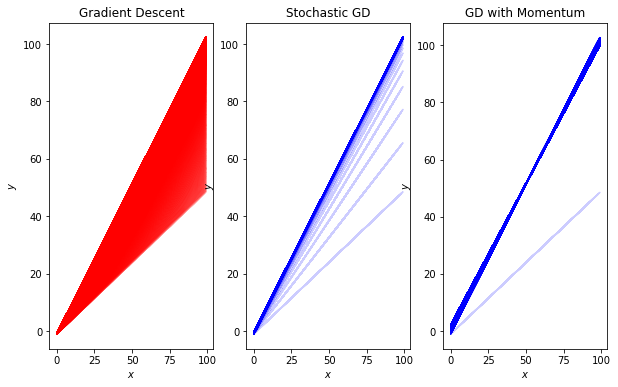

In [12]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 6))

s = min(hist1.shape[0], hist2.shape[0], hist3.shape[0])

for idx in range(s):
    y1_vals = [hist1[idx, 0] * x + hist1[idx, 1] for x in x_vals]
    ax0.plot(x_vals, y1_vals, 'r', alpha=0.2)
    
    y2_vals = [hist2[idx, 0] * x + hist2[idx, 1] for x in x_vals]
    ax1.plot(x_vals, y2_vals, 'b', alpha=0.2)
    
    y3_vals = [hist3[idx, 0] * x + hist3[idx, 1] for x in x_vals]
    ax2.plot(x_vals, y3_vals, 'b', alpha=0.2)

ax0.set_title('Gradient Descent')
ax1.set_title('Stochastic GD')
ax2.set_title('GD with Momentum')

for ax in [ax0, ax1, ax2]:
    ax.set_xlabel(r'$x$');
    ax.set_ylabel(r'$y$');